# Load and plot measured skew-spectra and plot theory for varying bias values #

In [1]:
from __future__ import print_function, division


%matplotlib inline
%config InlineBackend.figure_format = 'retina'


from nbodykit import style

from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.interpolate import interp1d

plt.style.use(style.notebook)
colors = [d['color'] for d in style.notebook['axes.prop_cycle']]

## Global params ##

In [2]:
theo_basedir = '../data/azadeh_16oct2020/'
Rsmooth = 10.
poles = [0]

# Sims: read options
sim_seeds = range(400,406)
#sim_seeds = [400]
boxsize = 1500.
Ngrid = 512
APPLY_RSD = 1
# 0.0015 or 0.04 or None (for initial runs that used 0.0015 subsample)
subsample_ratio = 0.04

# None (old code), 'catalog', 'delta_2SPT'
density_source = 'delta_2SPT'

b1_b2_bG2_f_lst = [(2.,-0.5,-0.4,0.786295), (2.4,-0.5,-0.4,0.786295), (2.,-1.0,-0.4,0.786295), (2.,-0.5,-0.8,0.786295), (2.,-0.5,-0.4,0.943554)]
bf_theo_string_lst = ['_base', '_base_b1t20p', '_base_b2t2', '_base_bs2t2', '_base_ft20p', ]

if density_source in [None,'catalog']:
    # velocity source: DM_sim (or '' in old runs), deltalin_D2, deltalin_D2_SPT2
    velocity_source = 'DM_sim'
    # max RSD displacement
    maximum_displacement = 100.0   # don't use None any more, bug!
else:
    velocity_source = None
    maximum_displacement = None

# z=0 to z=0.6 in ms_gadget cosmology
z_rescalefac = 0.7336055475

## Read and plot all RSD skew spectra from disk ##

In [3]:
def get_texname(skewspec):
    return '\mathcal{S}_{%s}' % skewspec[1:]

def get_theo_texname(name):
    texdict = {
        '_base': r'Base', 
        '_base_b1t20p': r'$1.2\times b_1$',
        #'_base_b2t20p': r'$1.2\times b_2$',
        '_base_b2tm20p': r'$1.2\times b_2$',
        '_base_ft20p': r'$1.2\times f$',
        '_base_bs2tm20p': r'$1.2\times b_{s2}$',
        '_base_b2t2':r'$2\times b_2$',
        '_base_bs2t2': r'$2\times b_{s2}$',
    }
    return texdict.get(name, name)

In [4]:
# read theory power for denominator
Ptheo = np.genfromtxt(os.path.join(theo_basedir, 'p_deltadelta.txt'), names=True)
interp_lnPtheo_lnk_Plin = interp1d(np.log(Ptheo['k']), np.log(Ptheo['P_link']))
interp_Ptheo_k_Plin = lambda k: np.exp(interp_lnPtheo_lnk_Plin(np.log(k)))
if 0 in poles:
    interp_lnPtheo_lnk_P0 = interp1d(np.log(Ptheo['k']), np.log(Ptheo['P_0k']))
    interp_Ptheo_k_P0 = lambda k: np.exp(interp_lnPtheo_lnk_P0(np.log(k)))
if 2 in poles:
    interp_lnPtheo_lnk_P2 = interp1d(np.log(Ptheo['k']), np.log(Ptheo['P_2k']))
    interp_Ptheo_k_P2 = lambda k: np.exp(interp_lnPtheo_lnk_P2(np.log(k)))
if 4 in poles:
    interp_lnPtheo_lnk_P4 = interp1d(np.log(Ptheo['k']), np.log(Ptheo['P_4k']))
    interp_Ptheo_k_P4 = lambda k: np.exp(interp_lnPtheo_lnk_P4(np.log(k)))



Reading ../data/Pskew_sims/00000400-01536-1500.0-wig/R10.0_Ng512_RSD1_DSdelta_2SPT_b2_-0.5_-0.4/Sn_ell0.txt
Reading ../data/Pskew_sims/00000401-01536-1500.0-wig/R10.0_Ng512_RSD1_DSdelta_2SPT_b2_-0.5_-0.4/Sn_ell0.txt
Reading ../data/Pskew_sims/00000402-01536-1500.0-wig/R10.0_Ng512_RSD1_DSdelta_2SPT_b2_-0.5_-0.4/Sn_ell0.txt
Reading ../data/Pskew_sims/00000403-01536-1500.0-wig/R10.0_Ng512_RSD1_DSdelta_2SPT_b2_-0.5_-0.4/Sn_ell0.txt
Reading ../data/Pskew_sims/00000404-01536-1500.0-wig/R10.0_Ng512_RSD1_DSdelta_2SPT_b2_-0.5_-0.4/Sn_ell0.txt
Reading ../data/Pskew_sims/00000405-01536-1500.0-wig/R10.0_Ng512_RSD1_DSdelta_2SPT_b2_-0.5_-0.4/Sn_ell0.txt
Reading ../data/azadeh_16oct2020/Sn_rsd_R10_base.txt
Reading ../data/azadeh_16oct2020/Sn_rsd_R10_base_b1t20p.txt
Reading ../data/azadeh_16oct2020/Sn_rsd_R10_base_b2t2.txt
Reading ../data/azadeh_16oct2020/Sn_rsd_R10_base_bs2t2.txt
Reading ../data/azadeh_16oct2020/Sn_rsd_R10_base_ft20p.txt
Reading ../data/azadeh_16oct2020/Sn_rsd_R10_base.txt
Reading ..

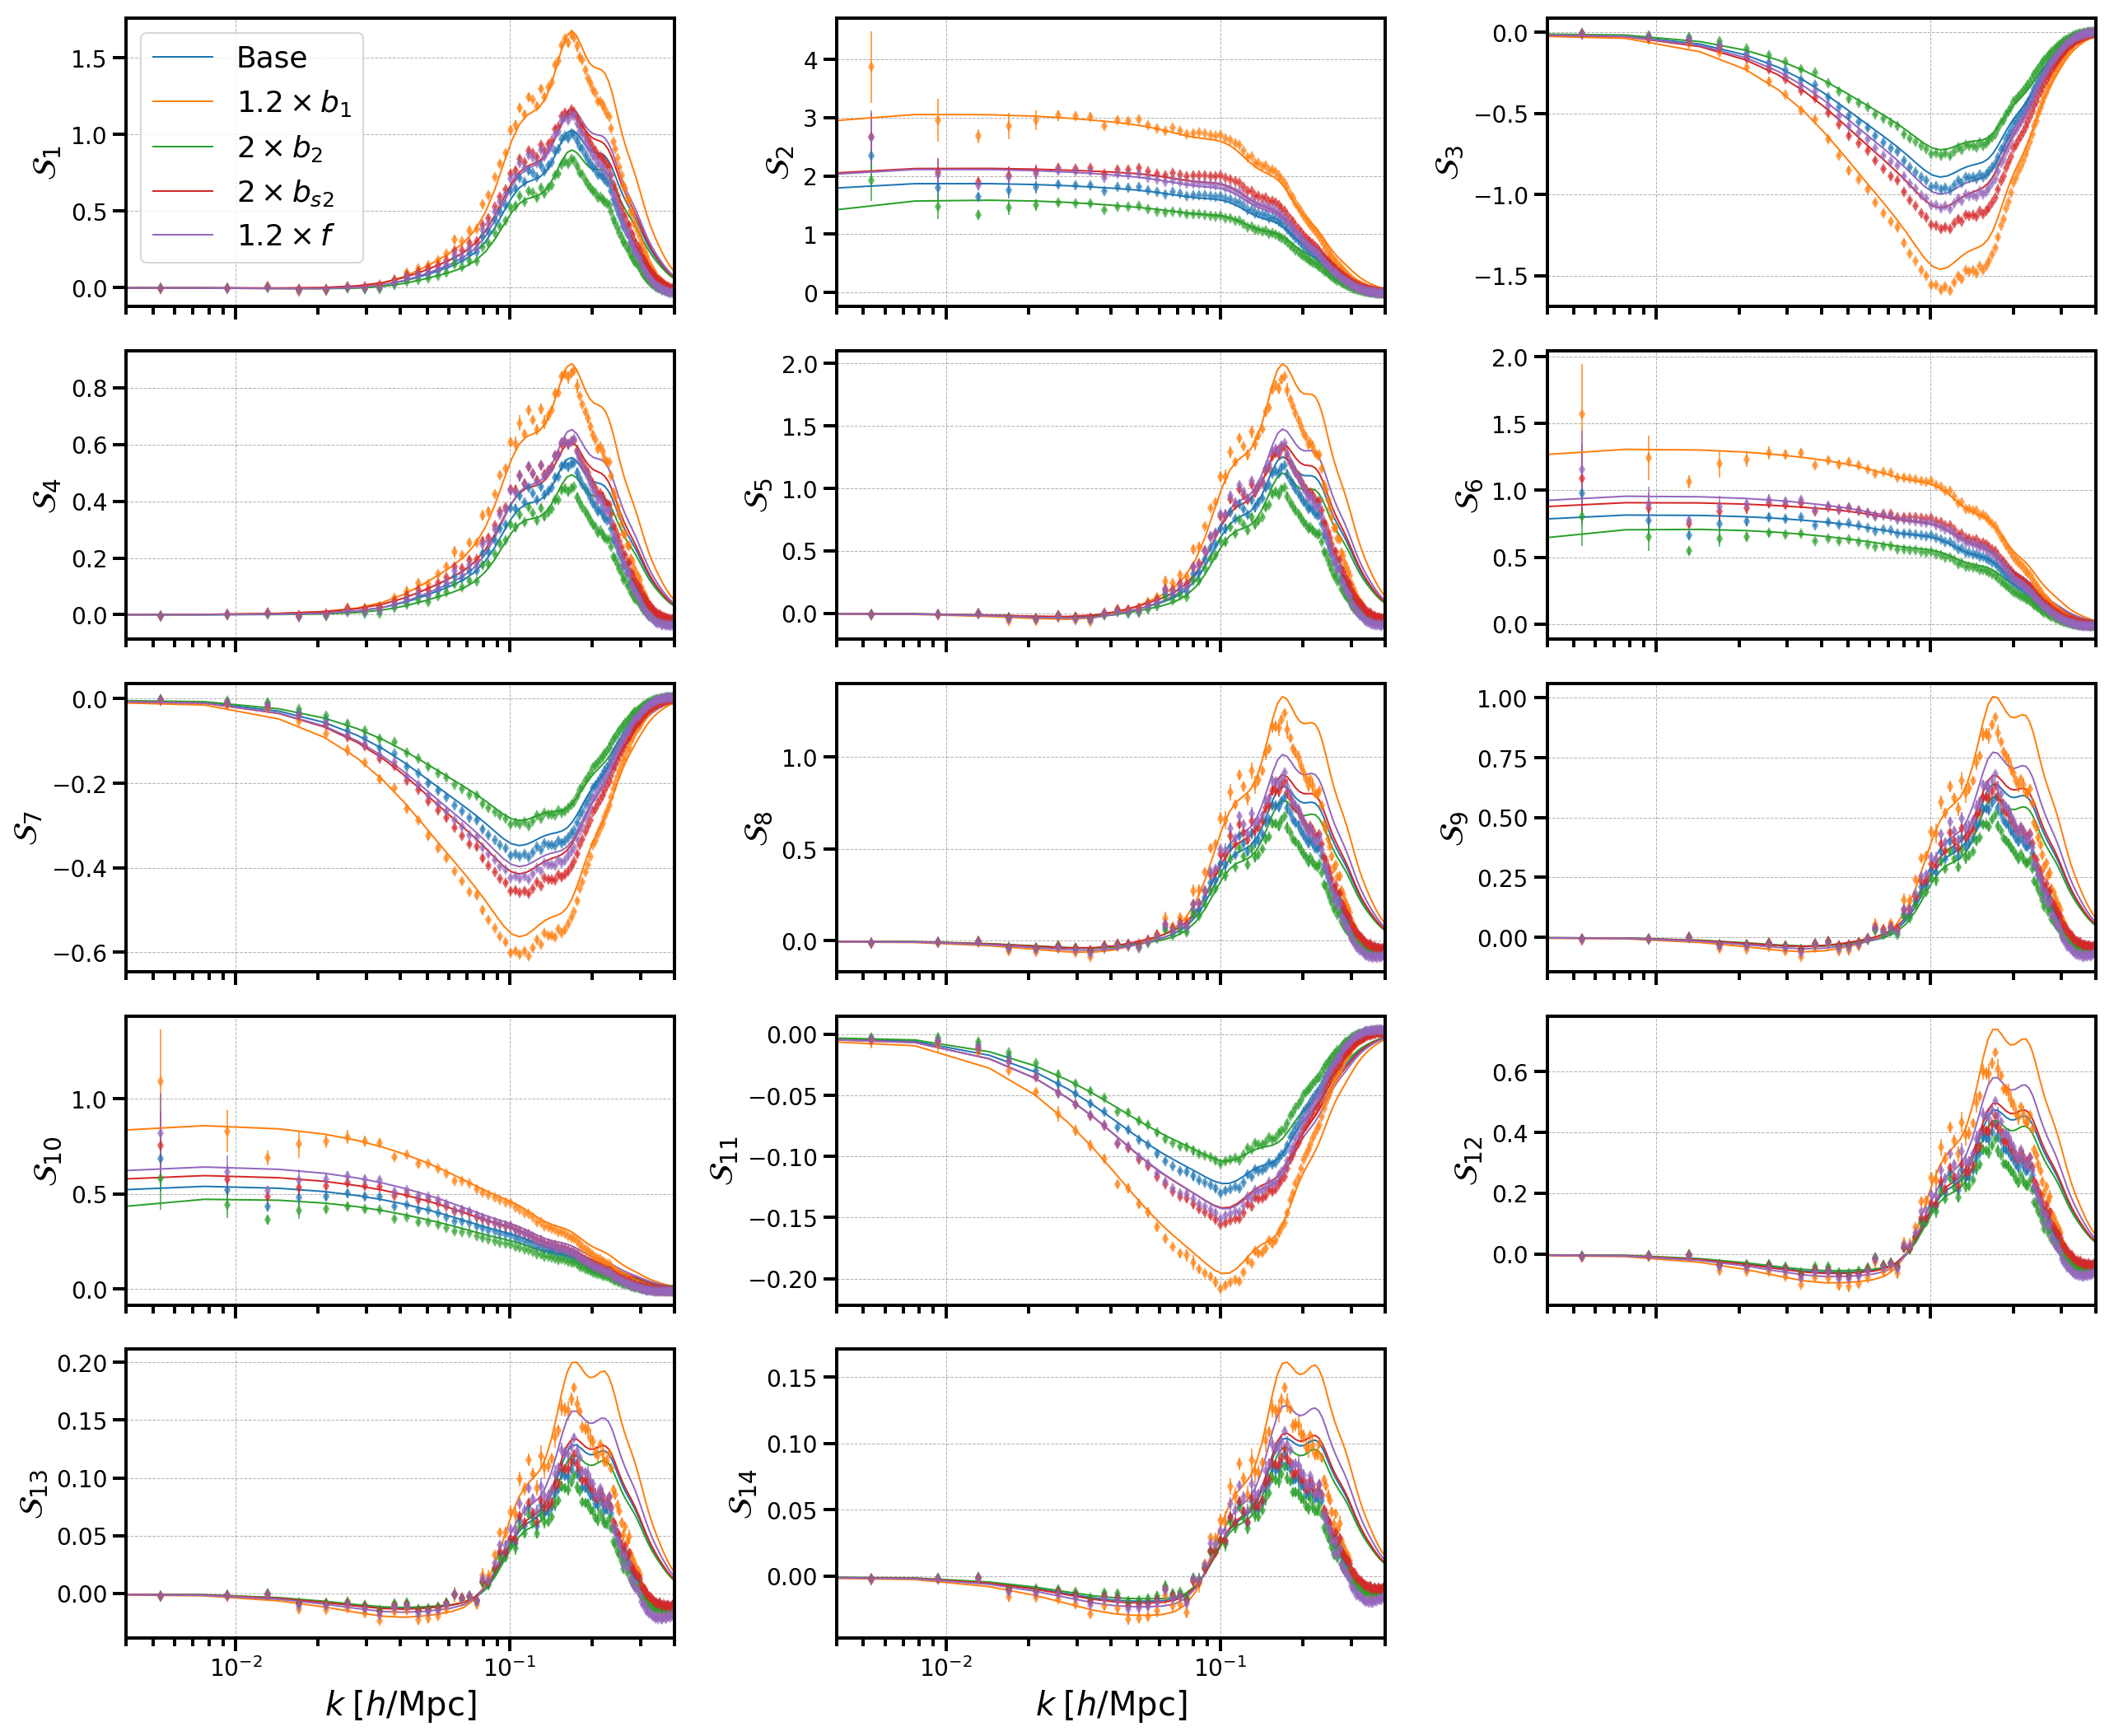

In [6]:
# read files
Nsims = len(sim_seeds)

for bf_counter, b1_b2_bG2_f in enumerate(b1_b2_bG2_f_lst):
    b1, b2, bG2, f_log_growth = b1_b2_bG2_f

    Pdd = {'power_%d' % ell: None for ell in poles}
    Sn = {'power_%d' % ell: None for ell in poles}
    skew_spectra = ['S%d'%d for d in range(1,15)]

    DS_string = '' if (density_source is None) else '_DS%s'%density_source

    if density_source in [None,'catalog']:
        sr_string = '' if (subsample_ratio is None) else '_sr%g' % subsample_ratio
        vel_string = '' if (velocity_source in ['', None]) else '_v%s' % velocity_source
        MD_string = '' if maximum_displacement is None else '_MD%g' % maximum_displacement
    else:
        sr_string, vel_string, MD_string = '', '', ''
    if density_source == 'catalog':
        b_string, f_string = '', ''
    elif density_source == 'delta_2SPT':
        b_string = '' if (b1==1. and b2==0. and bG2==0.) else ('_b%g_%g_%g' % (b1,b2,bG2))
        f_string = '' if f_log_growth==0.786295 else ('_f%g' % f_log_growth)


    for isim, sim_seed in enumerate(sim_seeds):
        for ell in poles:
            Pskew_sims_dir = '../data/Pskew_sims/00000%d-01536-%.1f-wig/R%.1f_Ng%d_RSD%d%s%s%s%s%s%s/' % (
                sim_seed, boxsize, Rsmooth, Ngrid,
                int(APPLY_RSD), DS_string, sr_string, vel_string, MD_string, b_string, f_string)

            # read measured skew spectrum
            fname = os.path.join(Pskew_sims_dir, 'Sn_ell%d.txt'%ell)
            print('Reading %s' % fname)

            if os.path.exists(fname):

                if Sn['power_%d'%ell] is None:
                    # get shape
                    tmp = np.genfromtxt(fname, names=['k']+skew_spectra)
                    Nk = tmp.shape[0]
                    Sn['power_%d'%ell] = OrderedDict()
                    for key in tmp.dtype.names:
                        Sn['power_%d'%ell][key] = np.zeros((Nsims, Nk)) + np.nan

                tmp = np.genfromtxt(fname, names=['k']+skew_spectra)
                for key in tmp.dtype.names:
                    Sn['power_%d'%ell][key][isim,:] = tmp[key]

            if False:
                # also read density power
                fname = os.path.join(Pskew_sims_dir, 'P_ell%d.txt'%ell)
                print('Reading %s' % fname)

                if Pdd['power_%d'%ell] is None:
                    # get shape
                    tmp = np.genfromtxt(fname, names=['k','P'])
                    Nk = tmp.shape[0]
                    Pdd['power_%d'%ell] = OrderedDict()
                    for key in tmp.dtype.names:
                        Pdd['power_%d'%ell][key] = np.zeros((Nsims, Nk)) + np.nan

                tmp = np.genfromtxt(fname, names=['k','P'])
                for key in tmp.dtype.names:
                    Pdd['power_%d'%ell][key][isim,:] = tmp[key]

           
    #########################
    # PLOT
    #########################
    layout = '3x5'

    if bf_counter == 0:
        if layout == '2x7':
            fig, axarr = plt.subplots(7,2,figsize=(6*2,3*7), sharex=True, sharey=False)
        elif layout == '3x5':
            fig, axarr = plt.subplots(5,3,figsize=(6*3,3*5), sharex=True, sharey=False)

    ell = 0
    color = colors[bf_counter]
    fs = 20
    ymax = 0.12
    ymin = -0.12

    kvec = np.mean(Sn['power_%d'%ell]['k'], axis=0)
    ww = np.where(kvec<=1.0)[0]

    for counter, skew_spec in enumerate(skew_spectra[:]):
        if layout == '2x7':
            ax = axarr[counter%7,counter//7]
        elif layout == '3x5':
            ax = axarr[counter//3,counter%3]   

        if ax == axarr[0,0]:
            do_legend = True
        else:
            do_legend = False

        # plot measurements
        if APPLY_RSD:
            if False:
                # divide by measured P_l
                ax.semilogx(kvec[ww], skew_spec.Pskew.poles['power_%d'%ell].real[ww]/Pdd.poles['power_%d'%ell].real[ww], marker='o', lw=0,
                             label=r'$\ell=%d$'%ell, color=color, markersize=5)

        # divide by theory P_l
        if APPLY_RSD:
            if ell==0:
                denomi = interp_Ptheo_k_P0(kvec[ww])
            elif ell==2:
                demomi = interp_Ptheo_k_P2(kvec[ww])
            else:
                denomi = np.nan
        else:
            denomi = interp_Ptheo_k_Plin(kvec[ww])
        ymat = Sn['power_%d'%ell][skew_spec][:,ww]
        if density_source == 'delta_2SPT':
            label = r'2SPT field' if do_legend else '_nolabel_'
        elif density_source == 'catalog':
            label = r'N-body DM' if do_legend else '_nolabel_'
        else:
            label = '_nolabel_'
        label = '_nolabel_'

        ax.errorbar(kvec[ww], 
                    np.mean(ymat, axis=0)/denomi,
                    yerr=np.std(ymat, axis=0)/denomi/np.sqrt(float(Nsims)), elinewidth=1,
                    marker='d', lw=0, color=color, alpha=0.7,
                     label=label, markersize=5)

        if bf_counter == 0:
            # read & plot theory skew spectra 
            realnames = ['k'] + ['S%dp_lin' %d for d in range(1,15)]
            #Sn_real_theo = np.genfromtxt(os.path.join(theo_basedir, 'Sn_real_R%d.txt' % int(Rsmooth)), names=realnames)
            for bf_theo_counter, bf_theo_string in enumerate(bf_theo_string_lst):
                Sn_rsd_theo = OrderedDict()
                ell = 0
                rsdnames = ['k'] + ['S%d' % d for d in range(1,15)]
                theo_fname = os.path.join(theo_basedir, 'Sn_rsd_R%d%s.txt' % (int(Rsmooth),bf_theo_string))
                print('Reading %s' % theo_fname)
                Sn_rsd_theo[(ell,)] = np.genfromtxt(theo_fname, names=rsdnames)
                #print(Sn_rsd_theo[(ell,)].dtype.names)
                tcolor = colors[bf_theo_counter]
                mylabel = get_theo_texname(bf_theo_string)
                if APPLY_RSD:
                    # S_n/Pl
                    if skew_spec in Sn_rsd_theo[(ell,)].dtype.names:
                        label = mylabel if do_legend else '_nolabel_'
                        ax.semilogx(Sn_rsd_theo[(ell,)]['k'], Sn_rsd_theo[(ell,)][skew_spec], color=tcolor, label=label,
                            lw=1)
                else:
                    # S_n/Plin
                    if skew_spec+'p_lin' in Sn_real_theo.dtype.names:
                        ax.semilogx(Sn_real_theo['k'], Sn_real_theo[skew_spec+'p_lin'], label='theo', color=tcolor,
                            lw=1)

        # cosmetics
        ax.set_xlim((0.004, 0.4))
        #ax.set_ylim((ymin, ymax))
        if do_legend:
            ax.legend(loc='best', ncol=1, fontsize=fs-2)
        if APPLY_RSD:
            #ax.set_ylabel(r'$%s/P^\ell_{\delta\delta}$' % skew_spec)
            #ax.set_ylabel(r'$\langle%s\delta\rangle\,/\,\langle\delta\delta\rangle$' % get_texname(skew_spec))
            ax.set_ylabel(r'$%s$' % (get_texname(skew_spec)), fontsize=fs)
        else:
            ax.set_ylabel(r'$%s/P_\mathregular{lin}$' % (skew_spec), fontsize=fs)
     
if layout == '3x5':
    fig.delaxes(axarr[-1,-1])

axarr[-1,0].set_xlabel(r'$k\;[h/\mathrm{Mpc}]$', fontsize=fs)
axarr[-1,1].set_xlabel(r'$k\;[h/\mathrm{Mpc}]$', fontsize=fs)
if layout == '5x3':
    axarr[-1,2].set_xlabel(r'$k\;[h/\mathrm{Mpc}]$', fontsize=fs)

plt.tight_layout()

fname = '../pdf/skewV2_DM_L%g_R%.1f_Ng%d_RSD%d%s%s%s%s_varyb.pdf' % (boxsize, Rsmooth,Ngrid,int(APPLY_RSD), DS_string,sr_string, vel_string, MD_string)
plt.savefig(fname)
print('Made %s' % fname)


Reading ../data/Pskew_sims/00000400-01536-1500.0-wig/R10.0_Ng512_RSD1_DSdelta_2SPT_b2_-0.5_-0.4/Sn_ell0.txt
Reading ../data/Pskew_sims/00000401-01536-1500.0-wig/R10.0_Ng512_RSD1_DSdelta_2SPT_b2_-0.5_-0.4/Sn_ell0.txt
Reading ../data/Pskew_sims/00000402-01536-1500.0-wig/R10.0_Ng512_RSD1_DSdelta_2SPT_b2_-0.5_-0.4/Sn_ell0.txt
Reading ../data/Pskew_sims/00000403-01536-1500.0-wig/R10.0_Ng512_RSD1_DSdelta_2SPT_b2_-0.5_-0.4/Sn_ell0.txt
Reading ../data/Pskew_sims/00000404-01536-1500.0-wig/R10.0_Ng512_RSD1_DSdelta_2SPT_b2_-0.5_-0.4/Sn_ell0.txt
Reading ../data/Pskew_sims/00000405-01536-1500.0-wig/R10.0_Ng512_RSD1_DSdelta_2SPT_b2_-0.5_-0.4/Sn_ell0.txt
Reading ../data/azadeh_16oct2020/Sn_rsd_R10_base.txt
shape read: (65,)
Reading ../data/azadeh_16oct2020/Sn_rsd_R10_base_b1t20p.txt
shape read: (65,)
Reading ../data/azadeh_16oct2020/Sn_rsd_R10_base_b2t2.txt
shape read: (65,)
Reading ../data/azadeh_16oct2020/Sn_rsd_R10_base_bs2t2.txt
shape read: (65,)
Reading ../data/azadeh_16oct2020/Sn_rsd_R10_base_f

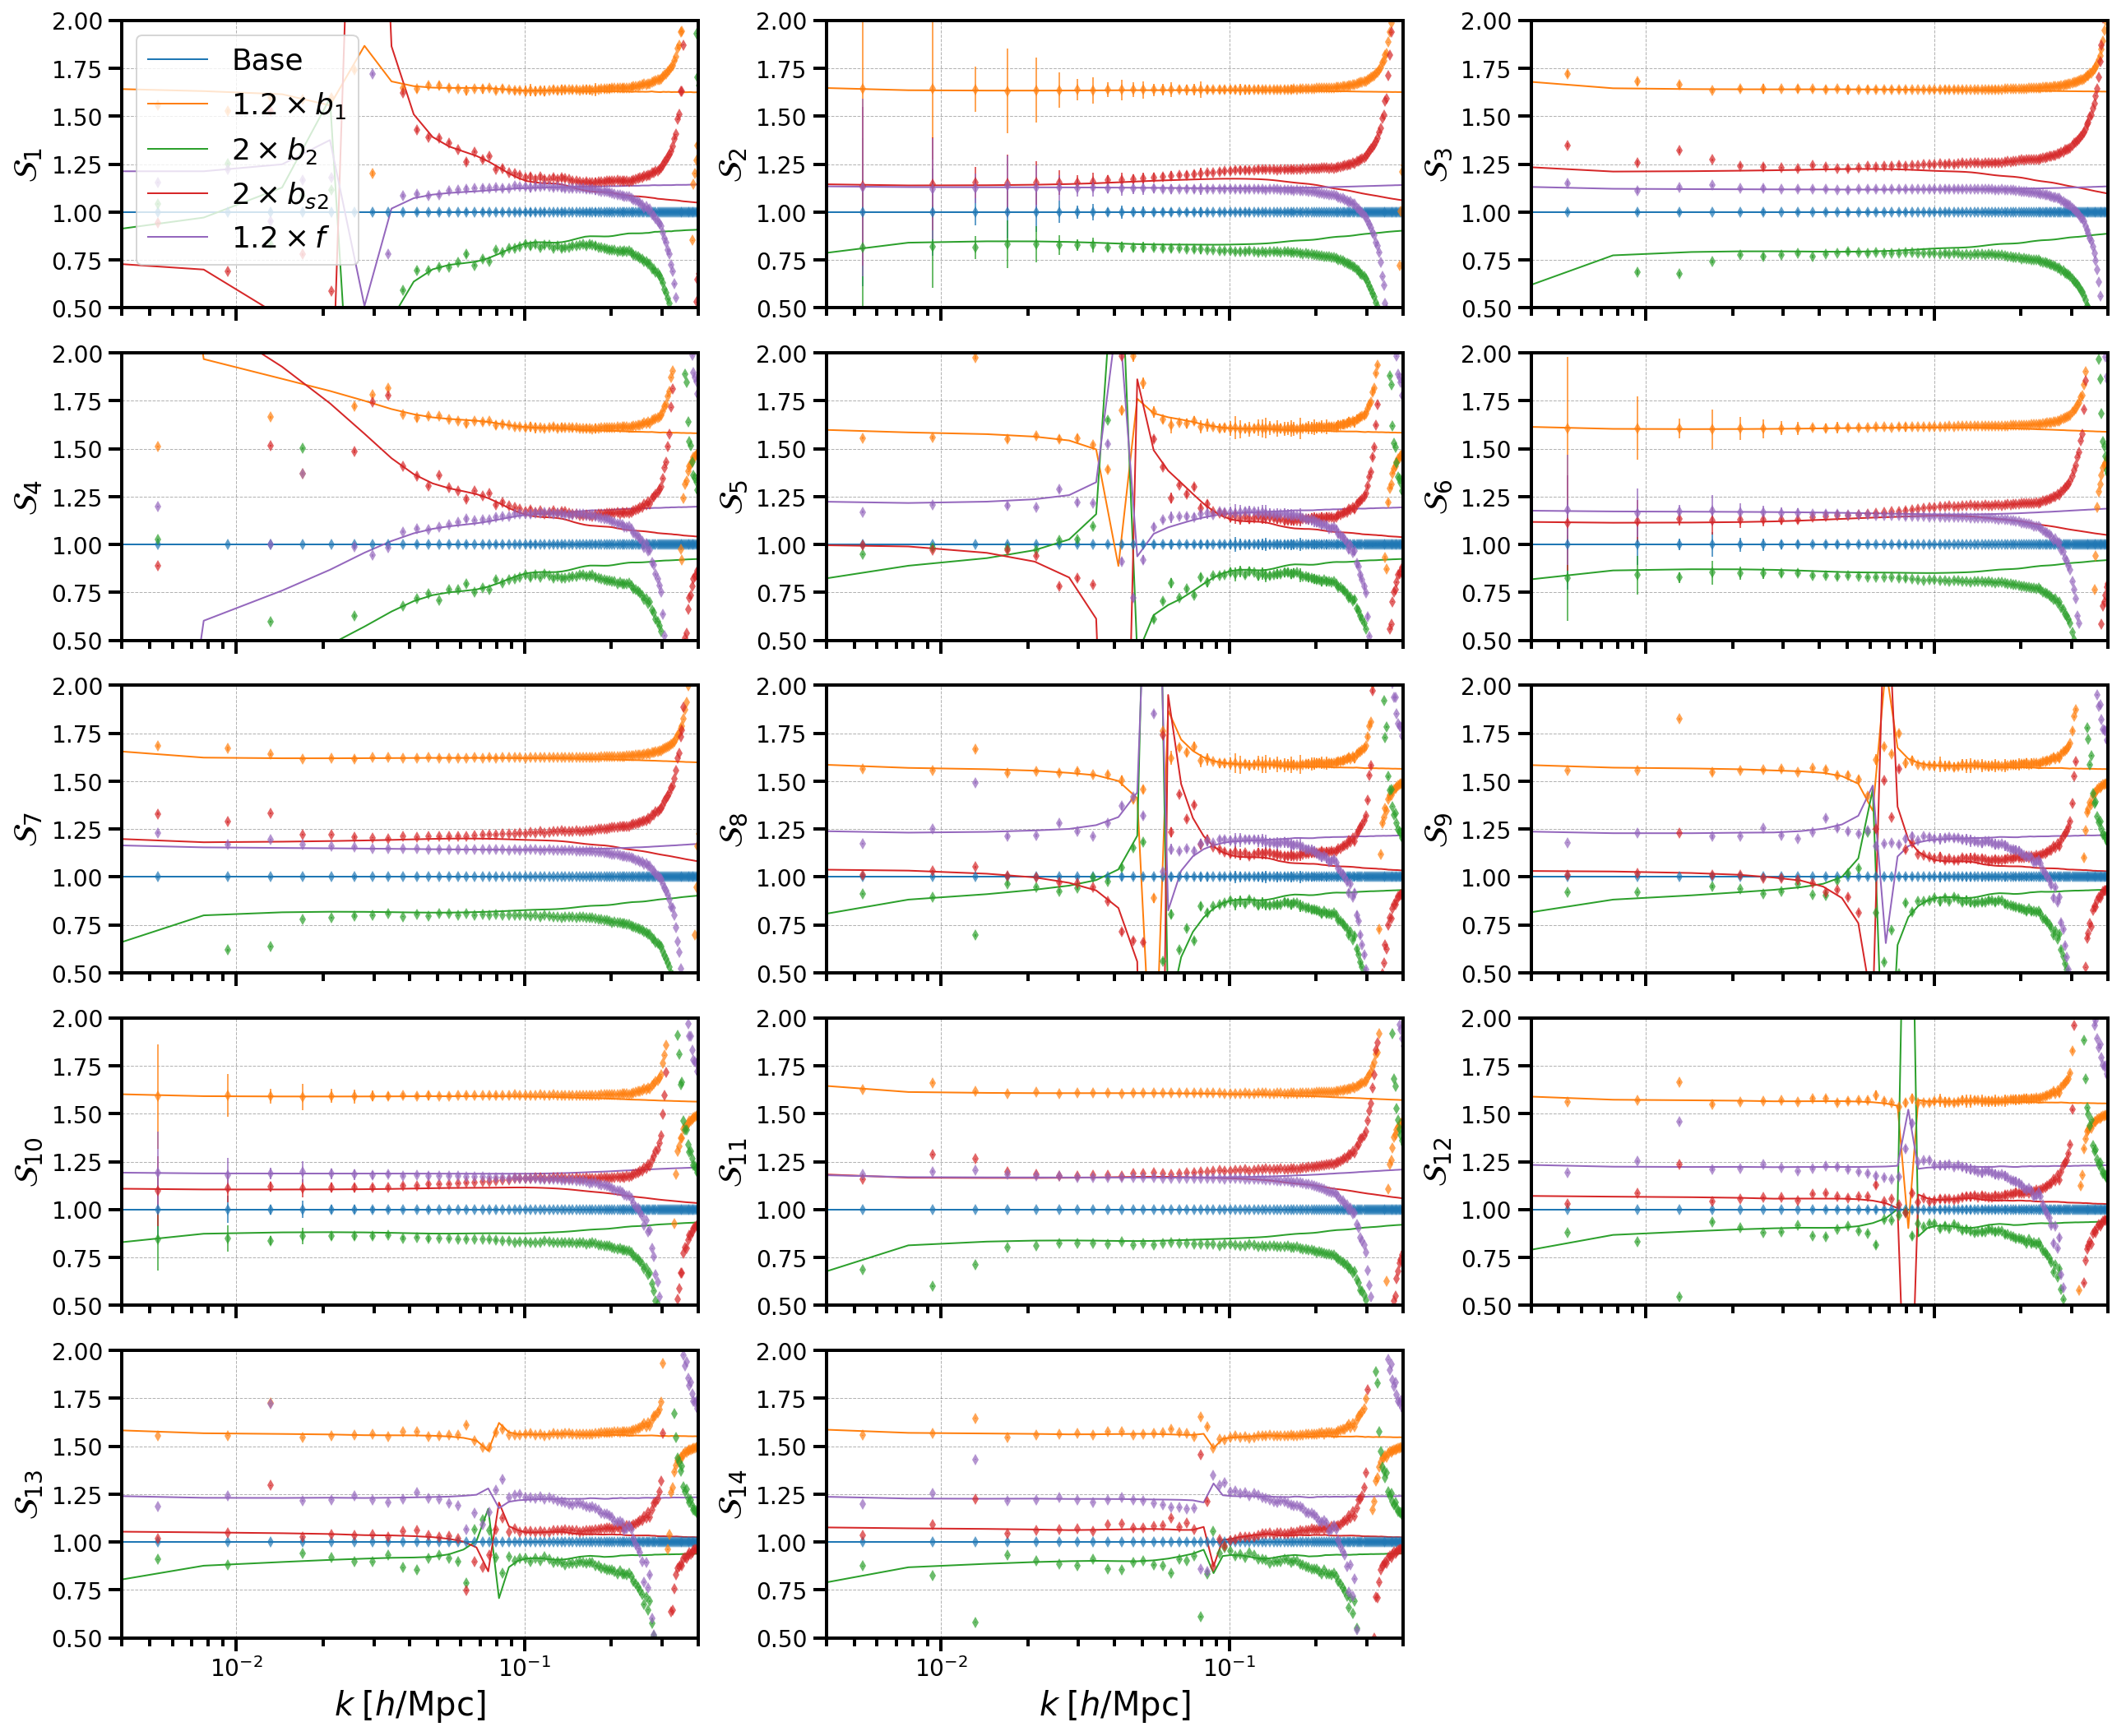

In [7]:
# plot fractional difference wrt base model

# read files
Nsims = len(sim_seeds)
base_measurements = OrderedDict()
base_theo_curve = OrderedDict()
interp_lnSntheo_ln_k = OrderedDict()
interp_Sntheo_k = OrderedDict()

for bf_counter, b1_b2_bG2_f in enumerate(b1_b2_bG2_f_lst):
    b1, b2, bG2, f_log_growth = b1_b2_bG2_f

    Pdd = {'power_%d' % ell: None for ell in poles}
    Sn = {'power_%d' % ell: None for ell in poles}
    skew_spectra = ['S%d'%d for d in range(1,15)]

    DS_string = '' if (density_source is None) else '_DS%s'%density_source

    if density_source in [None,'catalog']:
        sr_string = '' if (subsample_ratio is None) else '_sr%g' % subsample_ratio
        vel_string = '' if (velocity_source in ['', None]) else '_v%s' % velocity_source
        MD_string = '' if maximum_displacement is None else '_MD%g' % maximum_displacement
    else:
        sr_string, vel_string, MD_string = '', '', ''
    if density_source == 'catalog':
        b_string, f_string = '', ''
    elif density_source == 'delta_2SPT':
        b_string = '' if (b1==1. and b2==0. and bG2==0.) else ('_b%g_%g_%g' % (b1,b2,bG2))
        f_string = '' if f_log_growth==0.786295 else ('_f%g' % f_log_growth)


    for isim, sim_seed in enumerate(sim_seeds):
        for ell in [0]:
            Pskew_sims_dir = '../data/Pskew_sims/00000%d-01536-%.1f-wig/R%.1f_Ng%d_RSD%d%s%s%s%s%s%s/' % (
                sim_seed, boxsize, Rsmooth, Ngrid,
                int(APPLY_RSD), DS_string, sr_string, vel_string, MD_string, b_string, f_string)

            # read measured skew spectrum
            fname = os.path.join(Pskew_sims_dir, 'Sn_ell%d.txt'%ell)
            print('Reading %s' % fname)

            if os.path.exists(fname):

                if Sn['power_%d'%ell] is None:
                    # get shape
                    tmp = np.genfromtxt(fname, names=['k']+skew_spectra)
                    Nk = tmp.shape[0]
                    Sn['power_%d'%ell] = OrderedDict()
                    for key in tmp.dtype.names:
                        Sn['power_%d'%ell][key] = np.zeros((Nsims, Nk)) + np.nan

                tmp = np.genfromtxt(fname, names=['k']+skew_spectra)
                for key in tmp.dtype.names:
                    Sn['power_%d'%ell][key][isim,:] = tmp[key]

            if False:
                # also read density power
                fname = os.path.join(Pskew_sims_dir, 'P_ell%d.txt'%ell)
                print('Reading %s' % fname)

                if Pdd['power_%d'%ell] is None:
                    # get shape
                    tmp = np.genfromtxt(fname, names=['k','P'])
                    Nk = tmp.shape[0]
                    Pdd['power_%d'%ell] = OrderedDict()
                    for key in tmp.dtype.names:
                        Pdd['power_%d'%ell][key] = np.zeros((Nsims, Nk)) + np.nan

                tmp = np.genfromtxt(fname, names=['k','P'])
                for key in tmp.dtype.names:
                    Pdd['power_%d'%ell][key][isim,:] = tmp[key]

           
    #########################
    # PLOT
    #########################
    layout = '3x5'

    if bf_counter == 0:
        if layout == '2x7':
            fig, axarr = plt.subplots(7,2,figsize=(6*2,3*7), sharex=True, sharey=False)
        elif layout == '3x5':
            fig, axarr = plt.subplots(5,3,figsize=(6*3,3*5), sharex=True, sharey=False)

    ell = 0
    color = colors[bf_counter]
    fs = 20
    ymax = 0.12
    ymin = -0.12

    kvec = np.mean(Sn['power_%d'%ell]['k'], axis=0)
    ww = np.where(kvec<=1.0)[0]

    for counter, skew_spec in enumerate(skew_spectra[:]):
        if layout == '2x7':
            ax = axarr[counter%7,counter//7]
        elif layout == '3x5':
            ax = axarr[counter//3,counter%3]   

        if ax == axarr[0,0]:
            do_legend = True
        else:
            do_legend = False

        

        if bf_counter == 0:
            # read & plot theory skew spectra 
            realnames = ['k'] + ['S%dp_lin' %d for d in range(1,15)]
            #Sn_real_theo = np.genfromtxt(os.path.join(theo_basedir, 'Sn_real_R%d.txt' % int(Rsmooth)), names=realnames)
            for bf_theo_counter, bf_theo_string in enumerate(bf_theo_string_lst):
                Sn_rsd_theo = OrderedDict()
                ell = 0
                rsdnames = ['k'] + ['S%d' % d for d in range(1,15)]
                theo_fname = os.path.join(theo_basedir, 'Sn_rsd_R%d%s.txt' % (int(Rsmooth),bf_theo_string))
                print('Reading %s' % theo_fname)
                Sn_rsd_theo[(ell,)] = np.genfromtxt(theo_fname, names=rsdnames)
                print('shape read:', Sn_rsd_theo[(ell,)].shape)
                #print(Sn_rsd_theo[(ell,)].dtype.names)
                tcolor = colors[bf_theo_counter]
                mylabel = get_theo_texname(bf_theo_string)
                if APPLY_RSD and True:
                    # Plot theory
                    if skew_spec in Sn_rsd_theo[(ell,)].dtype.names:
                        label = mylabel if do_legend else '_nolabel_'
                        if bf_theo_counter == 0:
                            # get interpolator for base model curve
                            interp_Sntheo_k[skew_spec] = interp1d(
                                Sn_rsd_theo[(ell,)]['k'], Sn_rsd_theo[(ell,)][skew_spec], fill_value=np.nan, bounds_error=False)
                            #base_theo_curve[skew_spec] = Sn_rsd_theo[(ell,)][skew_spec]
                        #print('shape 1', base_theo_curve[skew_spec].shape)
                        #print('shape 2', Sn_rsd_theo[(ell,)][skew_spec].shape)
                        tkvec = Sn_rsd_theo[(ell,)]['k']
                        ax.semilogx(tkvec,
                                    Sn_rsd_theo[(ell,)][skew_spec]/interp_Sntheo_k[skew_spec](tkvec),
                                    color=tcolor, label=label, lw=1)
                elif not APPLY_RSD:
                    raise Exception('not implemented')

                    
        # plot measurements

        # divide by theory P_l
        if APPLY_RSD:
            if ell==0:
                denomi = interp_Ptheo_k_P0(kvec[ww])
            elif ell==2:
                demomi = interp_Ptheo_k_P2(kvec[ww])
            else:
                denomi = np.nan
        else:
            denomi = interp_Ptheo_k_Plin(kvec[ww])
        ymat = Sn['power_%d'%ell][skew_spec][:,ww]
        if density_source == 'delta_2SPT':
            label = r'2SPT field' if do_legend else '_nolabel_'
        elif density_source == 'catalog':
            label = r'N-body DM' if do_legend else '_nolabel_'
        else:
            label = '_nolabel_'
        label = '_nolabel_'
        
        if bf_counter == 0:
            base_measurements[skew_spec] = np.mean(ymat, axis=0)/denomi

        ax.errorbar(kvec[ww], 
                    np.mean(ymat, axis=0)/denomi / base_measurements[skew_spec],
                    #np.mean(ymat, axis=0)/denomi /interp_Sntheo_k[skew_spec](kvec[ww]),
                    yerr=np.std(ymat, axis=0)/denomi/np.sqrt(float(Nsims)), elinewidth=1,
                    marker='d', lw=0, color=color, alpha=0.7,
                     label=label, markersize=5)
                    
        # cosmetics
        ax.set_xlim((0.004, 0.4))
        ax.set_ylim((0.5,2))
        ax.set_xscale('log')

        #ax.set_ylim((ymin, ymax))
        if do_legend:
            ax.legend(loc='best', ncol=1, fontsize=fs-2)
        if APPLY_RSD:
            #ax.set_ylabel(r'$%s/P^\ell_{\delta\delta}$' % skew_spec)
            #ax.set_ylabel(r'$\langle%s\delta\rangle\,/\,\langle\delta\delta\rangle$' % get_texname(skew_spec))
            ax.set_ylabel(r'$%s$' % (get_texname(skew_spec)), fontsize=fs)
        else:
            ax.set_ylabel(r'$%s/P_\mathregular{lin}$' % (skew_spec), fontsize=fs)
           

     
if layout == '3x5':
    fig.delaxes(axarr[-1,-1])

axarr[-1,0].set_xlabel(r'$k\;[h/\mathrm{Mpc}]$', fontsize=fs)
axarr[-1,1].set_xlabel(r'$k\;[h/\mathrm{Mpc}]$', fontsize=fs)
if layout == '5x3':
    axarr[-1,2].set_xlabel(r'$k\;[h/\mathrm{Mpc}]$', fontsize=fs)

plt.tight_layout()

fname = '../pdf/skewV2_DM_L%g_R%.1f_Ng%d_RSD%d%s%s%s%s_varyb_fract.pdf' % (boxsize, Rsmooth,Ngrid,int(APPLY_RSD), DS_string,sr_string, vel_string, MD_string)
plt.savefig(fname)
print('Made %s' % fname)

